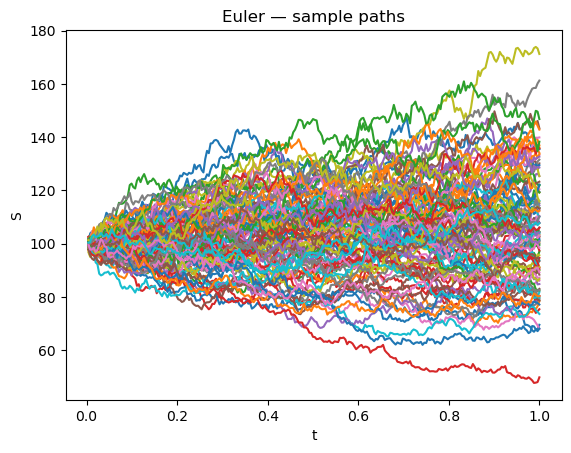

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("paths_euler_call.csv")
for pid, g in df.groupby("path_id"):
    plt.plot(g["t"], g["S"])
plt.xlabel("t")
plt.ylabel("S")
plt.title("Euler — sample paths")
plt.show()


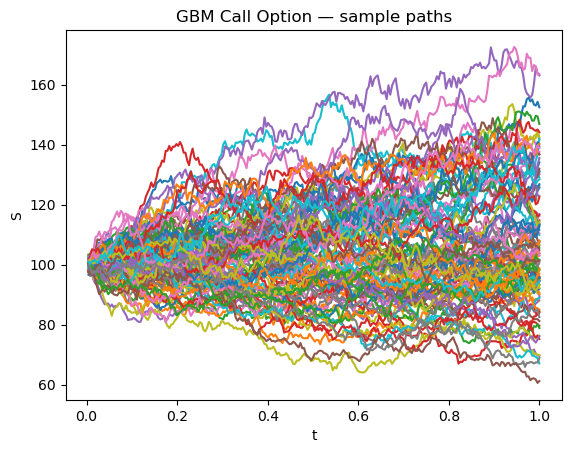

In [18]:
df = pd.read_csv("paths_gbm_call.csv")
for pid, g in df.groupby("path_id"):
    plt.plot(g["t"], g["S"])
plt.xlabel("t")
plt.ylabel("S")
plt.title("GBM Call Option — sample paths")
plt.show()

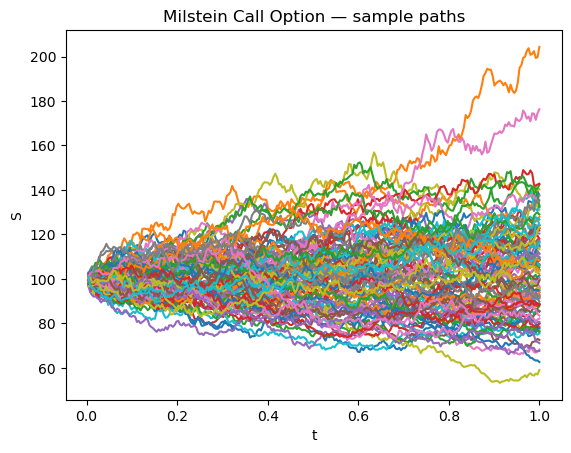

In [19]:
df = pd.read_csv("paths_milstein_call.csv")
for pid, g in df.groupby("path_id"):
    plt.plot(g["t"], g["S"])
plt.xlabel("t")
plt.ylabel("S")
plt.title("Milstein Call Option — sample paths")
plt.show()

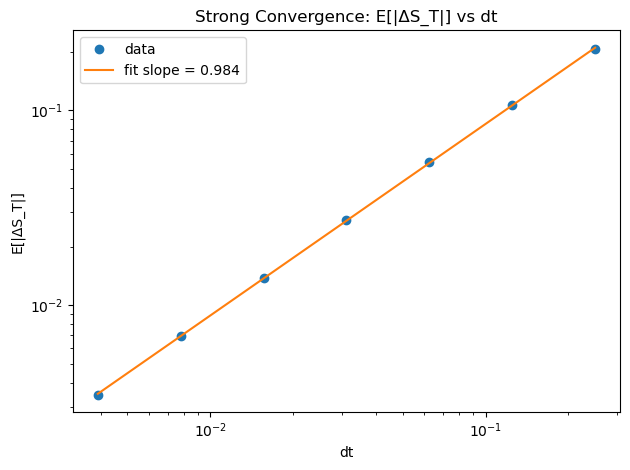

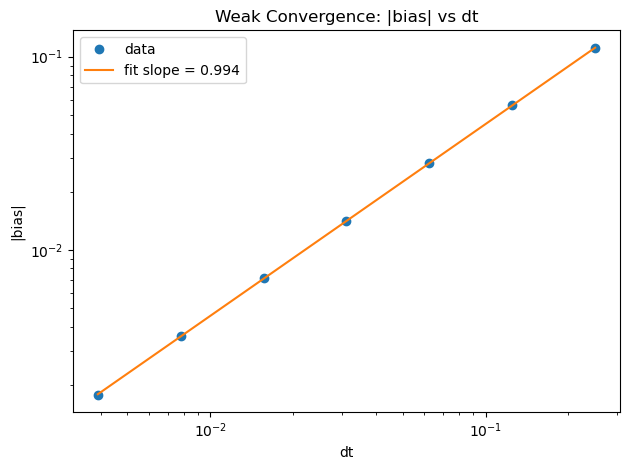

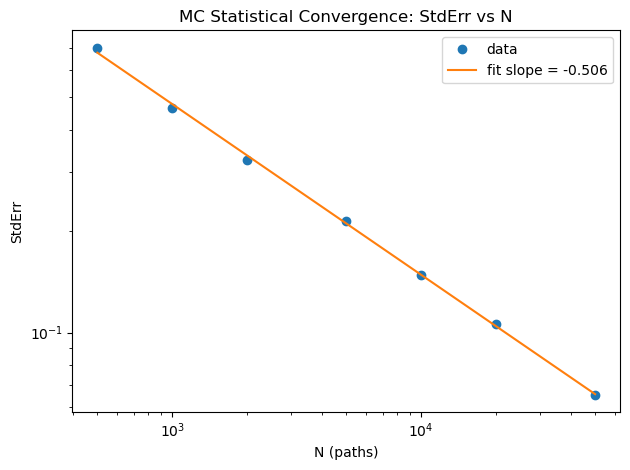

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_loglog_with_fit(csv_path, xcol, ycol, title, xlabel, ylabel):
    df = pd.read_csv(csv_path)
    x = df[xcol].to_numpy(dtype=float)
    y = df[ycol].to_numpy(dtype=float)

    # Use log10 (slope is base-invariant)
    X = np.log10(x)
    Y = np.log10(y)

    # Linear fit: Y = a + b X  => slope = b
    b, a = np.polyfit(X, Y, 1)

    # Build fitted line in original scale for display
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = 10**(a) * (x_fit**b)

    # Plot
    plt.figure()
    plt.loglog(x, y, 'o', label='data')
    plt.loglog(x_fit, y_fit, '-', label=f'fit slope = {b:.3f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Strong: dt vs E[|ΔS_T|]
plot_loglog_with_fit('strong_meanabs.csv',
                     xcol='dt', ycol='E_abs_dS',
                     title='Strong Convergence: E[|ΔS_T|] vs dt',
                     xlabel='dt', ylabel='E[|ΔS_T|]')

# (Optional) Strong RMS:
# plot_loglog_with_fit('strong_rms.csv', 'dt', 'RMS_dS',
#                      'Strong Convergence: RMS(ΔS_T) vs dt', 'dt', 'RMS(ΔS_T)')

# 2) Weak: dt vs |bias|
plot_loglog_with_fit('weak_bias.csv',
                     xcol='dt', ycol='abs_bias',
                     title='Weak Convergence: |bias| vs dt',
                     xlabel='dt', ylabel='|bias|')

# 3) MC statistical: N vs StdErr (expect slope ~ -1/2)
plot_loglog_with_fit('mc_stat_stderr.csv',
                     xcol='N', ycol='StdErr',
                     title='MC Statistical Convergence: StdErr vs N',
                     xlabel='N (paths)', ylabel='StdErr')


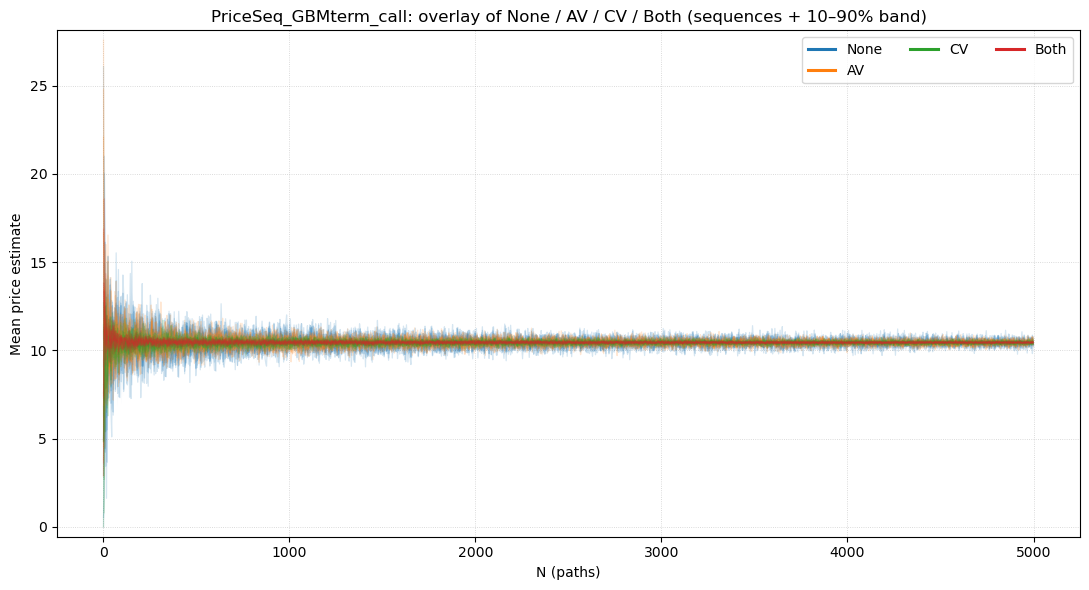

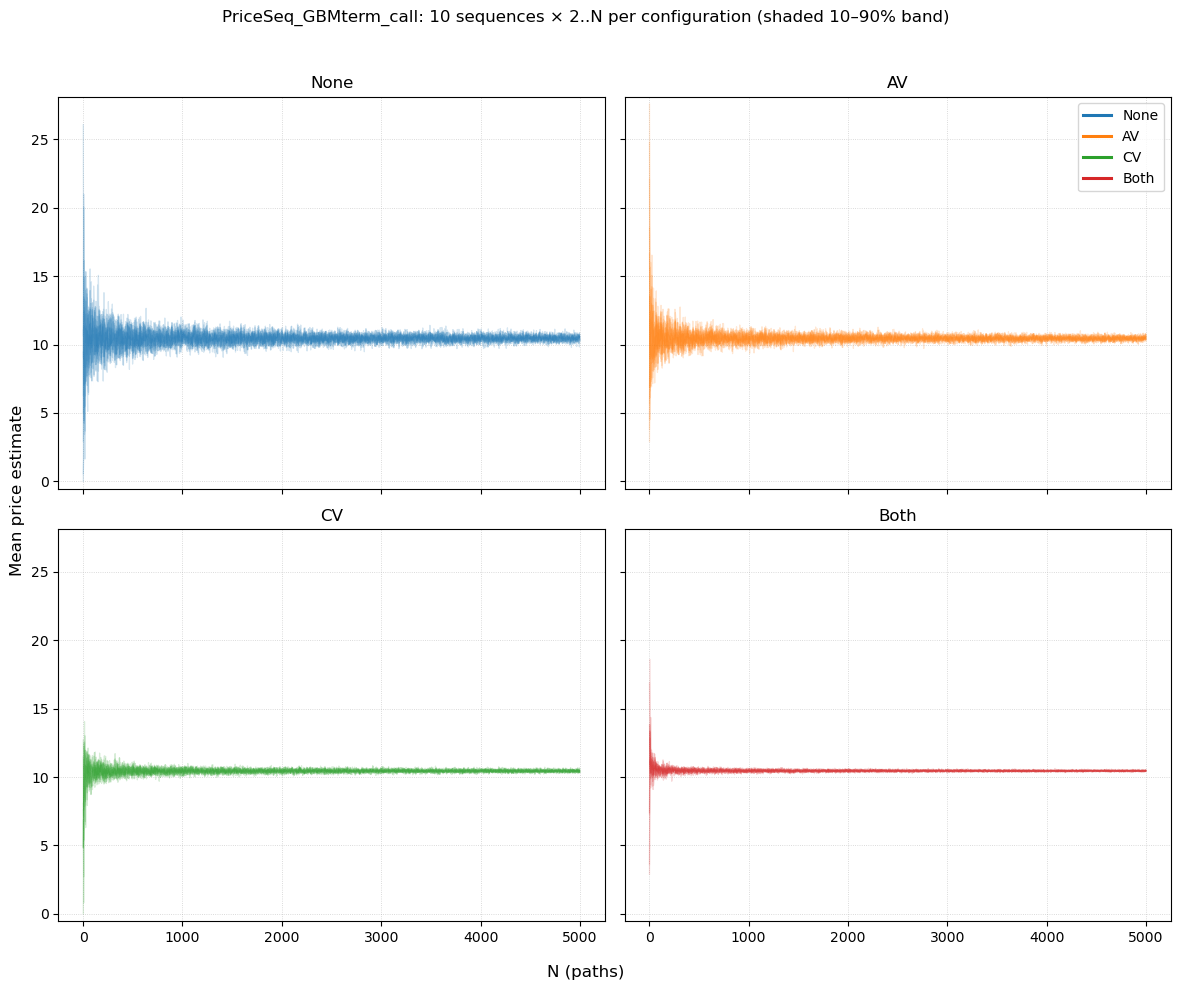

In [21]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================== USER SETTINGS =====================
# Base tag written by your C++ exporter:
#   - "PriceSeq_Euler_call"
#   - "PriceSeq_GBMterm_call"
base = "PriceSeq_GBMterm_call"

# Optional closed-form reference price (float) or None to skip
theory_price_call = None  # e.g., 10.450584

# Plot cosmetics
alpha_seq   = 0.18   # transparency for individual sequences
lw_seq      = 0.9    # line width for individual sequences
figsize_overlay = (11, 6)
figsize_grid    = (12, 10)

# Quantile band settings (set to None to disable)
quantiles = (0.10, 0.90)   # 10–90% band
alpha_band = 0.15

# Downsample (to keep plots responsive). Use None for auto.
# If auto, it picks a step so each sequence contributes at most ~2000 points.
fixed_stride = None   # e.g., 5 or 10; or None for auto
# ========================================================

files = {
    "None": f"{base}_none.csv",
    "AV":   f"{base}_av.csv",
    "CV":   f"{base}_cv.csv",
    "Both": f"{base}_both.csv",
}

colors = { "None": "C0", "AV": "C1", "CV": "C2", "Both": "C3" }

# ---------- Load & basic checks ----------
data = {}
ymins, ymaxs = [], []
nmax_seen = 0
for label, path in files.items():
    if not os.path.exists(path):
        print(f"[warn] Missing file: {path} — skipping '{label}'")
        continue
    df = pd.read_csv(path)  # expects: N, seq, price
    if not {"N", "seq", "price"}.issubset(df.columns):
        print(f"[warn] Unexpected columns in {path}: {df.columns.tolist()} — skipping")
        continue

    # Sort for safe plotting and quantiles
    df = df.sort_values(["N", "seq"]).reset_index(drop=True)
    data[label] = df
    ymins.append(df["price"].min())
    ymaxs.append(df["price"].max())
    if df["N"].max() > nmax_seen:
        nmax_seen = int(df["N"].max())

if not data:
    raise SystemExit("No CSV data found. Check 'base' and files existence.")

global_ymin = min(ymins)
global_ymax = max(ymaxs)
pad = 0.02 * (global_ymax - global_ymin if global_ymax > global_ymin else 1.0)
global_ylim = (global_ymin - pad, global_ymax + pad)

# Helper: choose stride
def choose_stride(df, fixed_stride, target_points_per_seq=2000):
    if fixed_stride and fixed_stride >= 1:
        return int(fixed_stride)
    # auto: pick stride so each sequence contributes ~target points
    nmax = int(df["N"].max())
    stride = max(1, nmax // target_points_per_seq)
    return stride

# Helper: draw one config (sequences + optional band) on given axes
def draw_config(ax, label, df, color, draw_legend=False, add_band=True):
    stride = choose_stride(df, fixed_stride)
    # sequences
    for seq_id, g in df.groupby("seq", sort=True):
        g = g.iloc[::stride, :]
        ax.plot(g["N"].values, g["price"].values,
                alpha=alpha_seq, linewidth=lw_seq, color=color, label=None)
    # quantile band
    if add_band and quantiles is not None:
        qlo, qhi = quantiles
        # Compute quantiles per N with downsampling to keep it light
        # (we reuse the same stride)
        band_df = (
            df.iloc[::stride, :]
              .groupby("N")["price"]
              .quantile([qlo, qhi])
              .unstack(level=1)
              .rename(columns={qlo: "lo", qhi: "hi"})
              .reset_index()
        )
        ax.fill_between(band_df["N"].values,
                        band_df["lo"].values,
                        band_df["hi"].values,
                        color=color, alpha=alpha_band, linewidth=0, label=None)
    if draw_legend:
        ax.plot([], [], color=color, linewidth=2.2, label=label)  # one handle per config

# ======================================================================
# (A) SINGLE-AXES OVERLAY (sequences + band, no bold mean line)
# ======================================================================
fig, ax = plt.subplots(figsize=figsize_overlay)

for i, (label, df) in enumerate(data.items()):
    draw_config(ax, label, df, colors.get(label, "C0"), draw_legend=True, add_band=True)

if theory_price_call is not None:
    ax.axhline(theory_price_call, linestyle="--", color="k", linewidth=1.5,
               label=f"Closed-form = {theory_price_call:.6f}")

ax.set_xlabel("N (paths)")
ax.set_ylabel("Mean price estimate")
ax.set_title(f"{base}: overlay of None / AV / CV / Both (sequences + {quantiles[0]*100:.0f}–{quantiles[1]*100:.0f}% band)")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
ax.set_ylim(*global_ylim)
ax.legend(ncol=3)
plt.tight_layout()
plt.show()

# ==========================================================
# (B) SQUARE 2×2 FIGURE (one subplot per config, sequences + band)
# ==========================================================
labels_in_order = ["None", "AV", "CV", "Both"]
fig, axes = plt.subplots(2, 2, figsize=figsize_grid, sharex=True, sharey=True)
axes = axes.ravel()

for ax, label in zip(axes, labels_in_order):
    if label not in data:
        ax.set_visible(False)
        continue
    df = data[label]
    draw_config(ax, label, df, colors.get(label, "C0"), draw_legend=False, add_band=True)

    if theory_price_call is not None:
        ax.axhline(theory_price_call, linestyle="--", color="k", linewidth=1.2)

    ax.set_title(label)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
    ax.set_ylim(*global_ylim)

fig.supxlabel("N (paths)")
fig.supylabel("Mean price estimate")
if quantiles is not None:
    qtxt = f" (shaded {int(quantiles[0]*100)}–{int(quantiles[1]*100)}% band)"
else:
    qtxt = ""
fig.suptitle(f"{base}: 10 sequences × 2..N per configuration{qtxt}", y=0.98)

# Show a compact legend once (top-right panel) with config labels
axes[1].plot([], [], color=colors["None"], linewidth=2.2, label="None")
axes[1].plot([], [], color=colors["AV"],   linewidth=2.2, label="AV")
axes[1].plot([], [], color=colors["CV"],   linewidth=2.2, label="CV")
axes[1].plot([], [], color=colors["Both"], linewidth=2.2, label="Both")
axes[1].legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
